In [1]:

#
# Corrections: 
# 50% unfit BCells die each replication cycle
# Don't kill Epitopes&Bcells when bound, just keep improve affinity 
# Clonal Burst -> large replication when close 


# Genitic Algorithims 
#https://deap.readthedocs.io/en/master/examples/ga_onemax.html




### Dependencies

In [2]:
import random 

import matplotlib.pyplot as plt

from deap import base, creator, tools

### Creating classes with .create

In [3]:
#DEAP creator to create custom individuals (classes) with fittness at runtime
# creator.creat (NAME, BASE CLASS, ATTRIBUES OF CLASS)
#creator.create("EpiFitnessMax", base.Fitness, weights=(1.0,)) #optimizing single objective: fitness. Single objectives is a special case of multi objectives (Minimize hamming distance)
creator.create("ABFitnessMin", base.Fitness, weights=(-1.0,)) #optimizing single objective: fitness. Single objectives is a special case of multi objectives (Minimize hamming distance)
creator.create("Individual", list, fitness=creator.ABFitnessMin)

### Toolbox: create types for our custom classes

In [4]:
EPI_OPTS = 48 # 48 bits in an epitope
toolbox = base.Toolbox()
toolbox.register("EpitopeOption", random.randint, 0, 1)
toolbox.register("Epitope", tools.initRepeat, creator.Individual, toolbox.EpitopeOption, EPI_OPTS) #Each Epitope has 48 bits - (6-8 amino acids with 3 4-bit base pairs)
toolbox.register("EpitopePop", tools.initRepeat, list, toolbox.Epitope) # Population of epitopes


toolbox.register("Antibody", tools.initRepeat, creator.Individual, toolbox.EpitopeOption, EPI_OPTS) #Each Antibody has 48 bits - (6-8 amino acids with 3 4-bit base pairs)
toolbox.register("ABPop", tools.initRepeat, list, toolbox.Antibody) # Population of Antibodies

### Evaluation Function
Need to evaluate fitness (hamming distance - number of different bits between antigen and and epitope)

In [133]:
def Hamming(Antibody, Epitope):
    #Returns list of hamming distances 
    #ASSUMES THE STRINGS ARE OF EVEN LENGTH 
    Antibody = Antibody[::2] #Gets every other bit to simulate the fact that many base pairs do not matter 
    Epitope = Epitope[::2] #Gets every other bit to simulate the fact that many base pairs do not matter 
    return sum(AB != Epi for AB, Epi in zip(Antibody, Epitope)) 

def evalAvgHamming(AB, EpitopeList):
   #print(EpitopeList)
   return sum( Hamming(AB, EP) for EP in EpitopeList) / len(EpitopeList),   #<- NOTICE! RETURN SINGLE TUPLE
        
def evalMinHamming(AB, EpitopeList):
   #print(EpitopeList)
   return min( Hamming(AB, EP) for EP in EpitopeList),  #<- NOTICE! RETURN SINGLE TUPLE

#Returns the best performing Antibody for each epitope
def evalMinEpHamming(EP, ABList):
   return min( Hamming(EP, AB) for AB in ABList)

def evalEpHamming(EP, ABList):
   return min( Hamming(EP, AB) for AB in ABList),

def evalRandHamming(AB, EpitopeList):
    EP = random.choice(EpitopeList)
    return Hamming(AB, EP),

def evalEPCount(Epitopes):
    return len(Epitopes)
    

In [134]:
test = [1,0,1]
test2 = [[1,1,1], [1,0,1]]

print(evalMinHamming(test,test2))


(0,)


### Genetic Operators

In [135]:
import random
def SelectBCells(ABpop):
    
    return random.sample(ABpop, len(ABpop)/2)

In [136]:
 #  Can call funtion from the tools module, 
 # or register it with arguments in a toolbox

toolbox.register("evaluateEP", evalEPCount) #dont include argument! 
toolbox.register("evaluateAvgHamming", evalAvgHamming) #dont include argument! 
toolbox.register("evaluateMinHamming", evalMinHamming) #dont include argument! 
toolbox.register("evaluateRandHamming", evalRandHamming) #dont include argument! 

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.0005) #There is a 10^-3 chance for any "base pair" to change 
toolbox.register("selectBest", tools.selBest) 
toolbox.register("selectRand", tools.selRandom)


In [137]:
def PrintStats(fits, pop):
      length = len(pop)
      mean = sum(fits) / length
      sum2 = sum(x*x for x in fits)
      std = abs(sum2 / length - mean**2)**0.5

      print("  Min %s" % min(fits))
      print("  Max %s" % max(fits))
      print("  Avg %s" % mean)
      print("  Std %s" % std)

def getAvgFitness(pop):
    #(Note, this is a an avg of averages )
    # Should expect half of half if just gessing (48/4 = 12)
    fits = [ind.fitness.values[0] for ind in pop]
    length = len(pop)
    avg = sum(fits) / length
    return float(avg)

#Get the best fitness from the ABpopulation for each Epitope
def getAvgFitnessEP(ABpop, EPlist):
      return sum([evalMinEpHamming(ABList=ABpop, EP=EP) for EP in EPlist])/len(EPlist)
          


      

In [164]:
import math
def showAvgFitness(avgFits):
    x = range(0,len(avgFits))

    plt.plot(x,avgFits)

    new_list = range(math.floor(min(x)), math.ceil(max(x))+1)
    plt.xticks(new_list)

    plt.xlabel("Generation")
    plt.ylabel("Average Antibody Binding Affinity")
    plt.show()

def showMinFitness(avgFits):
    x = range(0,len(avgFits))

    plt.plot(x,avgFits)

    new_list = range(math.floor(min(x)), math.ceil(max(x))+1)
    plt.xticks(new_list)

    plt.xlabel("Generation")
    plt.ylabel("Average of the Best Binding Affinities for each Epitope")
    plt.show()

In [165]:
def rejoinpop(pop1, pop2):
    #print("pop1 {} pop2 {}".format(pop1, pop2))
    pop = pop1 + pop2
    #print("Combined Pop {}".format(pop))
    return pop

In [166]:
## Best BCells undergo "clonal burst" 
def clonalBurst(Best):
    # Given the best BCells, we need to undergo mitosis twice (Quadruple pop.)
    CROSSOVER_RATE = .5
    
    # Clone the selected individuals 
    Bbest1 = list(map(toolbox.clone, Best))
    Bbest2 = list(map(toolbox.clone, Best))
    Bbest3 = list(map(toolbox.clone, Best))
    Bbest4 = list(map(toolbox.clone, Best))

    #Crossover
    for child1, child2 in zip(Bbest1[::2], Bbest1[1::2]):
        if random.random() < CROSSOVER_RATE:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    for child1, child2 in zip(Bbest2[::2], Bbest2[1::2]):
        if random.random() < CROSSOVER_RATE:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for child1, child2 in zip(Bbest3[::2], Bbest3[1::2]):
        if random.random() < CROSSOVER_RATE:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    for child1, child2 in zip(Bbest4[::2], Bbest4[1::2]):
        if random.random() < CROSSOVER_RATE:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    #Mutate
    for mutant in Bbest1:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    for mutant in Bbest2:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    for mutant in Bbest3:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    for mutant in Bbest4:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    Bbest12 = rejoinpop(Bbest1, Bbest2)
    Bbest34 = rejoinpop(Bbest3, Bbest4)

    #Crossover
    for child1, child2 in zip(Bbest12[::2], Bbest12[1::2]):
        if random.random() < CROSSOVER_RATE:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    for child1, child2 in zip(Bbest34[::2], Bbest34[1::2]):
        if random.random() < CROSSOVER_RATE:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    #Mutate
    for mutant in Bbest12:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    for mutant in Bbest34:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    AllBest = rejoinpop(Bbest12, Bbest34)
    #print("BCellBest length: {} ".format(len(BbestAll)))
    return AllBest




### Genetic algo time!

Current TODO: figure out how to combine populations after seperating. We seperate the 50%, select best 20%, but I can't figure out how to use deap to combine populations back after matching 

In [171]:
def GetAvgAff(epcount, abcount, supress, metric=1):
    # metric - set 1 for avg hamming, 2 for epitope perspective
    

    #create a list of 300 
    
    EpitopePop = toolbox.EpitopePop(epcount) #regestered method earlier 
    ABpop = toolbox.ABPop(n=abcount) #regestered method earlier 
        
    # Epitopes do not have fitness ``
    
    # assign fitnesses - 
    fitnesses = []
 
    for AB in ABpop:
        fitnesses.append(toolbox.evaluateAvgHamming(AB, EpitopePop))

    #print("fitnesses {}".format(fitnesses))
    for ind, fit in zip(ABpop, fitnesses):
        #print("index {}, fitness {}".format(ind, fit))
        ind.fitness.values = fit

    # CXPB  is the probability with which antibody & epitope bind
    # MUTPB is the probability for mutating 
    CXPB, MUTPB = 0.5, 1
    
    #Antibody
    ABfits = [ind.fitness.values[0] for ind in ABpop]
    
    # Variable keeping track of the number of generations
    g = 0
    
    EpFits = []
    # For accumulating the average fitness of each generation
    avgFits = []
    avgFits.append(getAvgFitness(ABpop))

    # Begin the evolution: evolve until the 1000th generation, or 100 population
    while g < 20:
        # A new generation
        g = g + 1
        if supress == 0:
            print("-- Generation %i --" % g)
            print("Num of BCells {} Num of Epitopes {}".format(len(ABpop), len(EpitopePop)))
 
        # Shuffle
        random.shuffle(ABpop)
        
        # Select the next generation individuals

        #50% of Bcells are tested each iteration, 25% most fit will continue 
        
        #Select 50% of the BCells to go to the LZ to test
        cellsLZ = ABpop[:len(ABpop)//2] 
        cellsDZ = ABpop[len(ABpop)//2:]
        #ABhalf = toolbox.selectRand(ABpop, int(len(ABpop)/2))
        if supress == 0:
            print("{} B Cells going to LZ ".format(len(cellsLZ)))
        
        #Select 25% of the LZ to go back to the DZ to reproduce
        best = toolbox.selectBest(cellsLZ, int(len(cellsLZ)/4))
        if supress == 0:
            print("{} B Cells get to return to DZ ".format(len(best)))

        
        # Best BCells undergo "clonal burst" - we need to get the 25% of the 50% BCells back up to 50%
        best = clonalBurst(clonalBurst(best))
        best = toolbox.selectRand(best, int(len(best)/2))
        #print("len best (should be 4x dcells returning to dz) {}".format(len(best)))

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in best if not ind.fitness.valid]
        fitnesses = []
        for ind in invalid_ind:
            if metric == 2:
                fitnesses.append(toolbox.evaluateMinHamming(ind, EpitopePop))
            else:
                fitnesses.append(toolbox.evaluateAvgHamming(ind, EpitopePop))
            
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Combine the B Cell populations
        #ABpop = rejoinpop(cellsDZ, best)
        ABpop = best

        #Update average fitnesses 
        EpFits.append(getAvgFitnessEP(ABpop, EpitopePop))
        avgFits.append(getAvgFitness(ABpop))

        if min(EpFits) < 2:
            print("Converged in {} Generations".format(g))
            break

    showAvgFitness(avgFits)  
    showMinFitness(EpFits)

    
    return min(avgFits), min(EpFits), g #Converged value returned\
    


-- Generation 1 --
Num of BCells 4096 Num of Epitopes 2
2048 B Cells going to LZ 
512 B Cells get to return to DZ 
-- Generation 2 --
Num of BCells 4096 Num of Epitopes 2
2048 B Cells going to LZ 
512 B Cells get to return to DZ 
Converged in 2 Generations


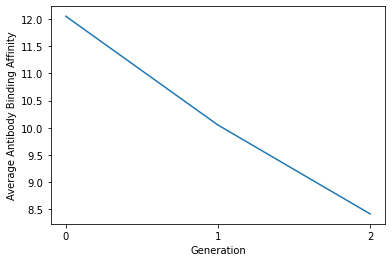

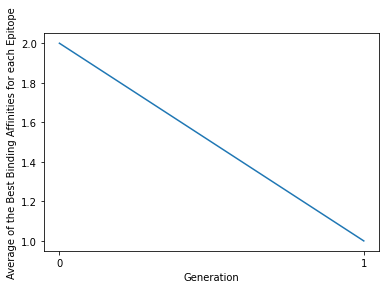

(8.4130859375, 1.0, 2)

In [172]:
GetAvgAff(epcount=2,abcount=4096, supress=0, metric=1)

Converged in 2 Generations


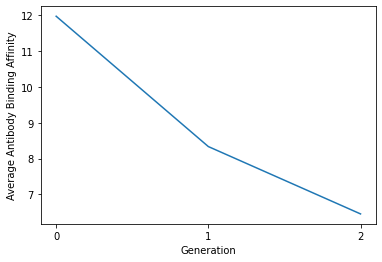

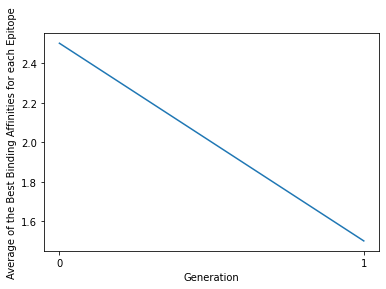

Converged in 1 Generations


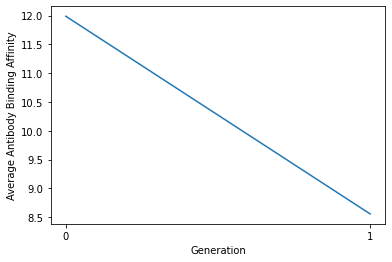

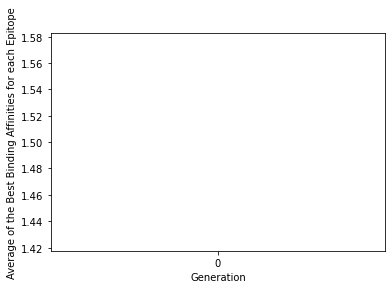

Converged in 2 Generations


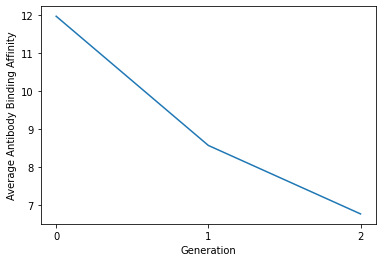

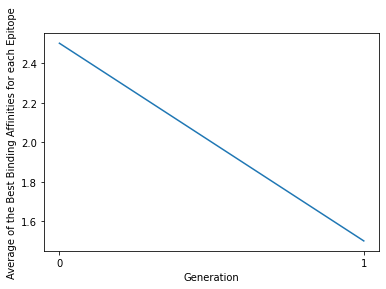

Converged in 2 Generations


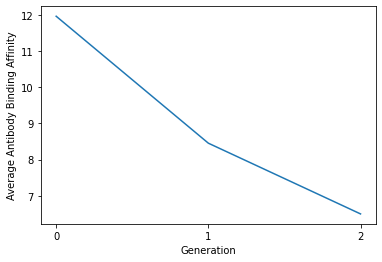

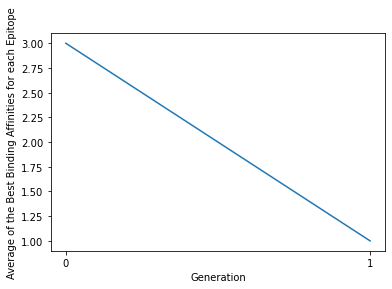

Converged in 2 Generations


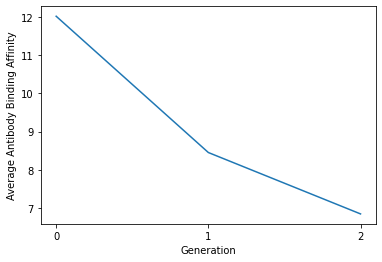

Converged in 2 Generations


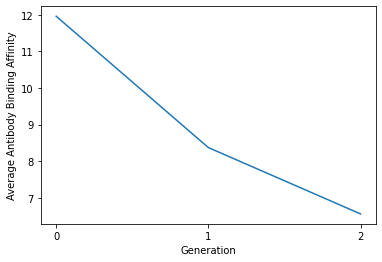

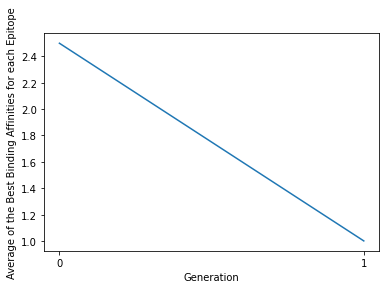

Converged in 2 Generations


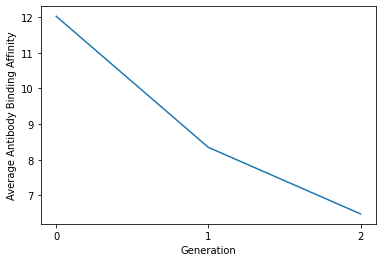

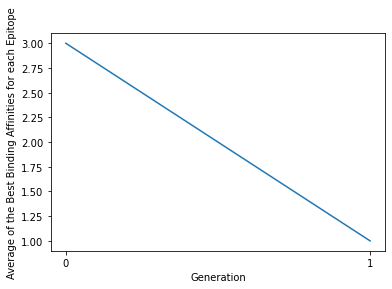

Converged in 3 Generations


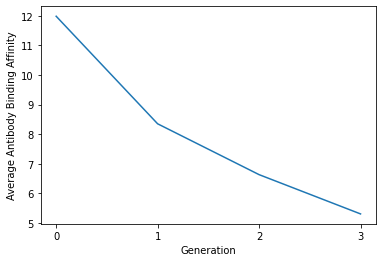

Converged in 2 Generations


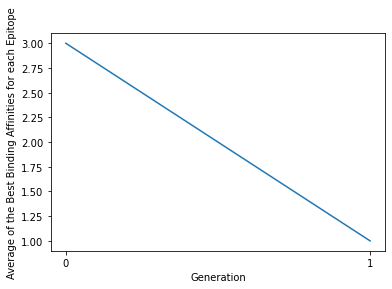

KeyboardInterrupt: 

In [173]:
#epcount = []
#avgAff = []
#for i in range(1,50, 1):
#    epcount.append(i)
#    avgAffAb, avgAffEp, g = GetAvgAff(epcount=2,abcount=4096, supress=1, metric=2)
#    avgAff.append(avgAffEp)


#### Varying Epitope count

Converged in 3 Generations


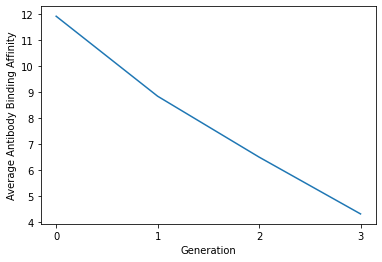

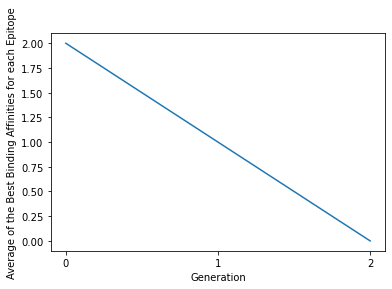

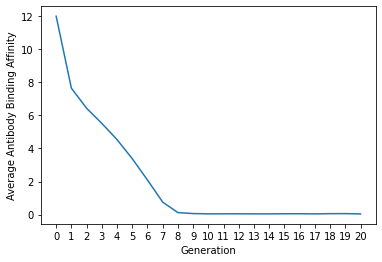

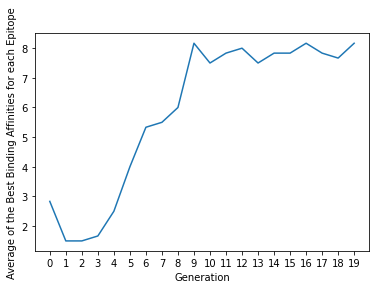

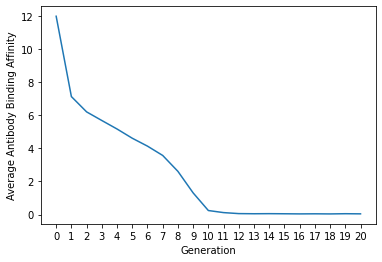

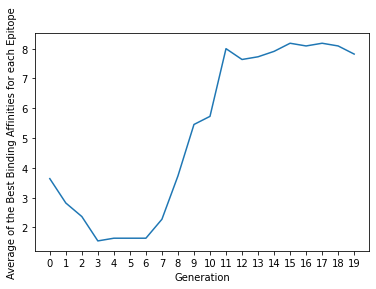

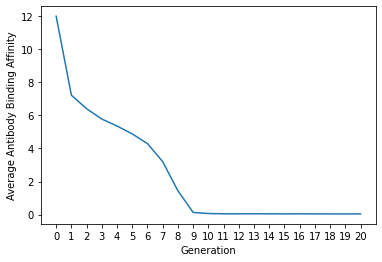

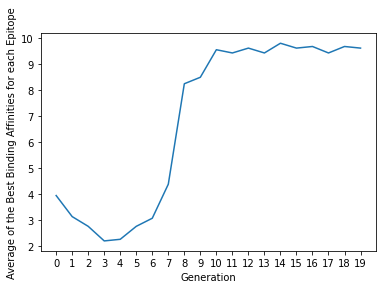

KeyboardInterrupt: 

In [170]:

epcount = []
avgAff = []
for i in range(1,50, 5):
    epcount.append(i)
    avgAffAb, avgAffEp, g = GetAvgAff(epcount=i,abcount=4096, supress=1, metric=2)
    avgAff.append(avgAffEp)



ValueError: x and y must have same first dimension, but have shapes (3,) and (2,)

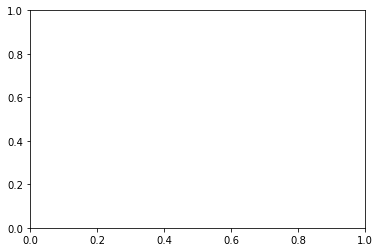

In [ ]:
plt.plot(epcount,avgAff)
plt.xlabel("Number of Epitopes")
plt.ylabel("Converged Minimum Average Affinity")
plt.show()